<div style="text-align: right">INFO 6105 Data Sci Engineering Methods and Tools, Week 4 Lecture 2</div>
<div style="text-align: right">Dino Konstantopoulos, 29 January 2020, with material from Cam Davidson-Pilon</div>

At the end of this lecture, you should a good understanding of probability distributions, how to estimate probabilities for different outcomes and sample spaces, and how to use Bayes' theorem to answer typical interview questions involving probabilities, and become curious about Formula 1 racing.



* * * 
# Introduction to Probability Distributions

<br />
<center>
<img src="http://statistics.wdfiles.com/local--files/ch6/binomial.png" width="400" />
Binomial
</center>

So far, we have made the assumption that every outcome in a sample space (urn) is ***equally likely***: Same probability to select White ball \#1 as Red ball \#5. 

>**Recall**: A probability is a **fraction** where the numerator is sum of all *favorable* outcomes, and the denominator the sum of all *possible* outcomes.

In real life, we often get outcomes that are not **equiprobable**. Foe example, White ball versus Red ball. For another example, the probability of a child being a girl is not exactly 1/2, and the probability is slightly different for a second child. 

An [article](http://people.kzoo.edu/barth/math105/moreboys.pdf) (good Data Science article, you should read it) gives the following *counts* for two-child families in Denmark, where `GB` means a family where the first child is a girl and the second a boy:

    GG: 121801    GB: 126840
    BG: 127123    BB: 135138
    
Because of this fact (not all urns yield Blue/Red/White *numbered* balls with equiprobable chances), we need to introduce three more definitions:

* [Frequency](https://en.wikipedia.org/wiki/Frequency_%28statistics%29): a number describing how often an outcome occurs. Can be a count like 121801, or a ratio like 0.515.

* [Distribution](http://mathworld.wolfram.com/StatisticalDistribution.html): A mapping from outcome to frequency for each possible outcome in a sample space. 

* [Probability Distribution](https://en.wikipedia.org/wiki/Probability_distribution): The distribution above, which has been *normalized* so that the sum of the frequencies is 1.

Here is an example of a ***super-popular*** probability distribution:
* The binomial distribution is frequently used to model the number of successes in a sample of size n drawn with replacement from a population of size N. It is parametrized by p and is the discrete probability distribution of the number of `yes`es in a sequence of n independent experiments *with replacement*, each asking a `yes/no` question, and each with its own boolean-valued outcome: a random variable containing a single bit of information: `yes` (with probability p) or `no` (with probability q = 1 − p)

* A single `yes/no` experiment is also called a *Bernoulli trial* or *Bernoulli experiment* and a sequence of outcomes is called a *Bernoulli process*

* For a single trial, i.e., n = 1, the binomial distribution is a Bernoulli distribution. 

So now we need to modify our awesome probability counting `p()` function (which takes each event as **equiprobable**) to take this miserable fact into account. Essentially, it's as if each *numbered ball* comes with its *own* probability of being picked. So we will need to use probability **dictionaries**.

<center>
    <img src="ipynb.images/miserable.png" width=300 />
</center>

((20, 0.2), (25, 0.6), (40, 0.6))


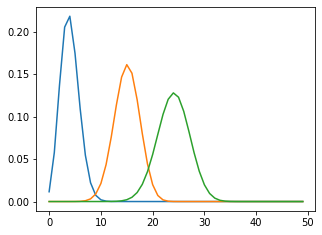

In [5]:
# first, let's plot a few binomial distributions
# n and p are exactly as defined above
import numpy as np
from scipy.stats import binom
from matplotlib import pyplot as plt
%matplotlib inline

n_values = [20, 25, 40]
p_values = [0.2, 0.6, 0.6]
x = np.arange(0, 50)

np = zip(n_values, p_values)
print(tuple(np))

fig, ax = plt.subplots(figsize=(5, 3.75))

for (n, p) in zip(n_values, p_values):
    # create a binomial distribution
    dist = binom(n, p)

    plt.plot(x, dist.pmf(x))

And for that, we need to digress a bit..

In Python, `*args` and `**kwargs` is a common idiom to allow ***arbitrary number of arguments*** to functions. `*args` will give you all function parameters as a tuple, `**kwargs` will give you all keyword arguments (except those corresponding to a formal parameter) as a dictionary:
```python
def foo(*args):
    for a in args:
    print a
        
def bar(**kwargs):
    for a in kwargs:
        print a, kwargs[a]
```

Let’s say we want to create a higher-order function that takes as input some function $f$ and returns a new function that for any input returns *twice* the value of $f$:

In [33]:
def doubler(f):
  def _(x):
    return 2 * f(x)
  return _

It works in most cases:

In [34]:
def f_plus_1(x):
  return x + 1;

h = doubler(f_plus_1)
print(h)
print(h(3))  # 8 = (3 + 1) * 2

<function doubler.<locals>._ at 0x1282993b0>
8


Now try this:

In [35]:
def sum2(x, y):
  return x + y;

h = doubler(sum2)
print(h(1,2)) #TypeError!

TypeError: _() takes 1 positional argument but 2 were given

Oopsie!

What we need is a way to specify a function that takes *arbitrary arguments*. This is where Python's `*args` and `**kwargs` come into play:

In [11]:
def magic(*args, **kwargs):
  print ("unnamed args: ", args)
  print ("keyword args: ", kwargs)
magic(1, 2, 3, 4,5,6,7, key1 = 'NU', key2 = 'rocks!', key3 = 'heart')

unnamed args:  (1, 2, 3, 4, 5, 6, 7)
keyword args:  {'key1': 'NU', 'key2': 'rocks!', 'key3': 'heart'}


In [12]:
def bar(**kwargs):
    for a in kwargs:
        print (a, kwargs[a])
bar( key1 = 'NU', key2 = 'rocks!', key3 = 'heart')

key1 NU
key2 rocks!
key3 heart


<br />
<center>
    <img src="ipynb.images/magic.png" width=300 />**Ohhhhhhhhhhhh**</a><br>Ni zheng bing!
</center>

args is a `tuple` of its unnamed arguments and kwargs is a `dictionary` of its named arguments. So now we can:

In [37]:
def doublerr(f):
  """works no matter the inputs"""
  def g(*args, **kwargs):
    """pass all arguments to f"""
    return 2 * f(*args, **kwargs)
  return g

and now:

In [38]:
g = doublerr(sum2)
print(g(1, 2))  # 6:

6


Now are ready to define **Probabiluty distributions** in python!

We define `ProbDist` to take the same kinds of arguments that dict does: either a **mapping** (from item to its probability) or a **set** of (key, val) pairs, and/or optional keyword arguments (because each ball in the urn is *special* now: it has its *own* probability of being picked). 

>**A dose of reality**: It's like all boys/girls are not equal! You will not just pick any boy/girl to be your girl/boyfriend! There are some that have a *much higher chance* of being picked by you (related to *your* taste)!

This is the first time (in class), that we will define a Python `class`, instead of a Python **function/lambda**. That is why we will define its **constructor** `__init__()`. We assume `self` (`this` in Python) is composed of a set:

In [36]:
class ProbDist(dict):
    """A Probability Distribution; an {outcome: probability} mapping."""
    def __init__(self, mapping=(), **kwargs):
        self.update(mapping, **kwargs)
        # print ('ProbDist', self);
        # Make probabilities sum to 1.0; assert no negative probabilities
        total = sum(self.values())
        for outcome in self:
            if self[outcome] == 0:
                self[outcome] = 0
            else:
                self[outcome] = self[outcome] / total
                assert self[outcome] >= 0

We also need to modify the functions `p` and `such_that` to accept either a sample space as we had previously, or a probability distribution as the second argument `space`. 

>**Oh-oh**: Now we need to branch out on the ***2nd argument** of function `p`!

If we have a probability distribution, instead of *counting* each possible outcome equiprobably and thus just summing up `1`s (numerator: sum of all *favorable* outcomes, denominator: sum of all *possible* outcomes), we need to sum up the different discrete probabilities of each possible outcome: `sum(space[o] for o in space if o in event)`. 

We also need to modify `such_that()`, which is the set of all outcomes of our sample space for which the predicate (first) argument is `True`, so that its second argument can also be a `ProbDist`.

In [37]:
def p(event, space): 
    """The probability of an event, given a sample space of equiprobable outcomes. 
    event: a collection of outcomes, or a predicate that is true of outcomes in the event. 
    space: a set of outcomes or a probability distribution of {outcome: frequency} pairs."""
    if is_predicate(event):
        ## print('here1')
        event = such_that(event, space)
    if isinstance(space, ProbDist):
        ## print('here2')
        ## print('here2-1', 'event', event, 'space', space)
        return sum(space[o] for o in space if o in event)
    else:
        print('here3')
        return Fraction(len(event & space), len(space))

is_predicate = callable

def such_that(predicate, space): 
    """The outcomes in the sample pace for which the predicate is true.
    If space is a set, return a subset {outcome,...} with outcomes where predicate(element) is true;
    if space is a ProbDist, return a ProbDist {outcome: frequency,...} with outcomes where predicate(element) is true."""
    if isinstance(space, ProbDist):
        ## print('here1-1')
        return ProbDist({o:space[o] for o in space if predicate(o)})
    else:
        ## print('here1-2')
        return {o for o in space if predicate(o)}

And now we can finally take on the Danes!
<br />
<center>
    <img src="ipynb.images/Danes.png" width=300 />
</center>

Here is the probability distribution for Danish two-child families as a dictionary describing the probability of each possible outcome:

In [38]:
DK = ProbDist(GG=121801, GB=126840,
              BG=127123, BB=135138)
DK

{'GG': 0.23840384261560926,
 'GB': 0.24826679089140383,
 'BG': 0.24882071317004043,
 'BB': 0.2645086533229465}

Let's write some useful predicates (lambdas):
```python
def first_girl(outcome):  return outcome[0] == 'G'
def first_boy(outcome):   return outcome[0] == 'B'
def second_girl(outcome): return outcome[1] == 'G'
def second_boy(outcome):  return outcome[1] == 'B'
def two_girls(outcome):   return outcome    == 'GG'
```
Using these predicates, answer the following questions:

* What's the probability for a girl, and is it higher or lower for a second girl?
* Is the sex of the second child more likely or less likely to be the same as the first child?

*Hint:* You will leverage `p(first_girl, DK)`, `p(second_girl, DK)`, `p(second_girl, such_that(first_girl, DK))`, and `p(second_girl, such_that(first_boy, DK))`

In [49]:
def first_girl(outcome):  return outcome[0] == 'G'
def first_boy(outcome):   return outcome[0] == 'B'
def second_girl(outcome): return outcome[1] == 'G'
def second_boy(outcome):  return outcome[1] == 'B'
def two_girls(outcome):   return outcome    == 'GG'

In [50]:
p(first_girl, DK)

here1
here1-1
ProbDist {'GG': 0.23840384261560926, 'GB': 0.24826679089140383}
here2
here2-1 event {'GG': 0.4898669165584115, 'GB': 0.5101330834415885} space {'GG': 0.23840384261560926, 'GB': 0.24826679089140383, 'BG': 0.24882071317004043, 'BB': 0.2645086533229465}


0.4866706335070131

In [51]:
p(second_girl, DK)

here1
here1-1
ProbDist {'GG': 0.23840384261560926, 'BG': 0.24882071317004043}
here2
here2-1 event {'GG': 0.48930999019781135, 'BG': 0.5106900098021886} space {'GG': 0.23840384261560926, 'GB': 0.24826679089140383, 'BG': 0.24882071317004043, 'BB': 0.2645086533229465}


0.4872245557856497

In [52]:
p(first_boy, DK)

here1
here1-1
ProbDist {'BG': 0.24882071317004043, 'BB': 0.2645086533229465}
here2
here2-1 event {'BG': 0.48471942072973107, 'BB': 0.5152805792702689} space {'GG': 0.23840384261560926, 'GB': 0.24826679089140383, 'BG': 0.24882071317004043, 'BB': 0.2645086533229465}


0.5133293664929869

In [53]:
p(second_boy, DK)

here1
here1-1
ProbDist {'GB': 0.24826679089140383, 'BB': 0.2645086533229465}
here2
here2-1 event {'GB': 0.48416279229553627, 'BB': 0.5158372077044637} space {'GG': 0.23840384261560926, 'GB': 0.24826679089140383, 'BG': 0.24882071317004043, 'BB': 0.2645086533229465}


0.5127754442143503

In [54]:
p(second_girl, such_that(first_girl, DK))

here1-1
ProbDist {'GG': 0.23840384261560926, 'GB': 0.24826679089140383}
here1
here1-1
ProbDist {'GG': 0.4898669165584115}
here2
here2-1 event {'GG': 1.0} space {'GG': 0.4898669165584115, 'GB': 0.5101330834415885}


0.4898669165584115

 P = ( p(GG) / ( P(GG) + P(GB) ) 

In [55]:
def second_girl_first_girl(outcome):
    if outcome[0] == 'G':
        return outcome[1] == 'G'

p(second_girl_first_girl, DK)

here1
here1-1
ProbDist {'GG': 0.23840384261560926}
here2
here2-1 event {'GG': 1.0} space {'GG': 0.23840384261560926, 'GB': 0.24826679089140383, 'BG': 0.24882071317004043, 'BB': 0.2645086533229465}


0.23840384261560926

The above says that the probability of a girl is somewhere between 48% and 49%, but that it is slightly different between the first or second child.

Now answer the question as to whether the sex of the second child is *more likely* or *less likely* to be the same as the first child, by evaluating first:

- The probability of a second girl given that the first child was a girl (a joint probability)
- The probability of a second girl given that the first child was a boy (a joint probability)
- The probability of a second boy given that the first child was a boy (a joint probability)
- The probability of a second boy given that the first child was a girl (a joint probability)

The average of the first two probabilities above represents the probability of a second girl, a [**marginal probability**](https://en.wikipedia.org/wiki/Marginal_distribution) in our problem.

The avergage of the last two probabilities above represents the probability of a second boy, a **marginal probability** in our problem.

In [67]:
p(second_girl, such_that(first_girl, DK)),p(second_girl, such_that(first_boy, DK))

(0.4898669165584115, 0.48471942072973107)

In [68]:
p(second_boy, such_that(first_girl, DK)),p(second_boy, such_that(first_boy, DK))

(0.5101330834415885, 0.5152805792702689)

The above says that the sex of the second child is more likely to be the same as the first child, by about 1/2 a percentage point.

You should find that the probability of a girl is somewhere between 48% and 49%, but slightly different between the first or second child, and that the sex of the second child is more likely to be the same as the first child, by about 1/2 a percentage point.

# 6. M&Ms and Bayes
<br />
<center>
<img src="https://upload.wikimedia.org/wikipedia/en/9/97/M%26M_spokescandies.jpeg" />
</center>

Here's another classic urn problem (or "bag" problem) [from](http://allendowney.blogspot.com/2011/10/my-favorite-bayess-theorem-problems.html) prolific Python/Probability author [Allen Downey ](http://allendowney.blogspot.com/), which also happens to be a classic interview question:

> The blue M&M was introduced in 1995.  Before then, the color mix in a bag of plain M&Ms was (30% Brown, 20% Yellow, 20% Red, 10% Green, 10% Orange, 10% Tan).  Afterward it was (24% Blue , 20% Green, 16% Orange, 14% Yellow, 13% Red, 13% Brown). 
A friend of mine has two bags of M&Ms, and he tells me that one is from 1994 and one from 1996.  He won't tell me which is which, but he gives me one M&M from each bag.  One is yellow and one is green.  What is the probability that the yellow M&M came from the 1994 bag? Well, the old M&M bags' yellow count was higher, so it must be higher, right? But how to count?

To solve this problem, we'll first represent probability distributions for each bag: `bag94` and `bag96`, by using `ProbDist` and passing in dictionaries for each year:
```python
bag94 = ProbDist(brown=30, yellow=20, red=20, green=10, orange=10, tan=10)
bag96 = ProbDist(...)  #fill this in, please
```

In [8]:
bag94 = ProbDist(brown=30, yellow=20, red=20, green=10, orange=10, tan=10)
print (bag94)
bag96 = ProbDist(blue=24, green=20, orange=16, yellow=14, red=13, brown=13)
print (bag96)

{'brown': 0.3, 'yellow': 0.2, 'red': 0.2, 'green': 0.1, 'orange': 0.1, 'tan': 0.1}
{'blue': 0.24, 'green': 0.2, 'orange': 0.16, 'yellow': 0.14, 'red': 0.13, 'brown': 0.13}


Next, define `MM` as the *joint* distribution 94-96&mdash;the sample space for picking *one* M&M from *each* bag. The outcome `'yellow green'` means that a yellow M&M was selected from the 1994 bag and a green one from the 1996 bag. We will use a *set comprehension*.

Uhhhh... What do we use for sets again? Is it `[`, or `(`, or `{`?

To note:
* We are using a python *set* because we care about dictionaries, and dictionary keys are unique
* You can also think in terms of JSON objects

```python
def joint(A, B, sep=''):
    """The joint distribution of two independent probability distributions. 
    Result is all entries of the form {a+sep+b: P(a)*P(b)}"""
    return ProbDist({a + sep + b: A[a] * B[b]
                    for ...
                    for ...})

MM = joint(bag94, bag96, ' ')
MM
```

In [9]:
def joint(A, B, sep=''):
    """The joint distribution of two independent probability distributions. 
    Result is all entries of the form {a+sep+b: P(a)*P(b)}"""
    return ProbDist({a + sep + b: A[a] * B[b] for a in A for b in B})
print('bag94', bag94)
print('bag96', bag96)
MM = joint(bag94, bag96, ' ')
MM

bag94 {'brown': 0.3, 'yellow': 0.2, 'red': 0.2, 'green': 0.1, 'orange': 0.1, 'tan': 0.1}
bag96 {'blue': 0.24, 'green': 0.2, 'orange': 0.16, 'yellow': 0.14, 'red': 0.13, 'brown': 0.13}


{'brown blue': 0.07199999999999997,
 'brown green': 0.05999999999999997,
 'brown orange': 0.04799999999999998,
 'brown yellow': 0.04199999999999998,
 'brown red': 0.038999999999999986,
 'brown brown': 0.038999999999999986,
 'yellow blue': 0.04799999999999998,
 'yellow green': 0.03999999999999999,
 'yellow orange': 0.03199999999999999,
 'yellow yellow': 0.02799999999999999,
 'yellow red': 0.025999999999999992,
 'yellow brown': 0.025999999999999992,
 'red blue': 0.04799999999999998,
 'red green': 0.03999999999999999,
 'red orange': 0.03199999999999999,
 'red yellow': 0.02799999999999999,
 'red red': 0.025999999999999992,
 'red brown': 0.025999999999999992,
 'green blue': 0.02399999999999999,
 'green green': 0.019999999999999993,
 'green orange': 0.015999999999999993,
 'green yellow': 0.013999999999999995,
 'green red': 0.012999999999999996,
 'green brown': 0.012999999999999996,
 'orange blue': 0.02399999999999999,
 'orange green': 0.019999999999999993,
 'orange orange': 0.015999999999999

Let's look at the "One is yellow and one is green" part:

```python
def yellow_and_green(outcome): return 'yellow' in outcome and 'green' in outcome

such_that(...) # fill this in
```

In [170]:
def yellow_and_green(outcome): return 'yellow' in outcome and 'green' in outcome
such_that(yellow_and_green, MM)

here1-1
ProbDist {'yellow green': 0.03999999999999999, 'green yellow': 0.013999999999999995}


{'yellow green': 0.7407407407407408, 'green yellow': 0.25925925925925924}

Now we can answer the question: given that we got a yellow and a green (but don't know which comes from which bag), what is the probability that the yellow came from the 1994 bag?

```python
def yellow94(outcome): return ...

p(yellow94, such_that(...)) # fill this in
```

In [171]:
def yellow94(outcome): return outcome.startswith('yellow')

p(yellow94, such_that(yellow_and_green, MM))

here1-1
ProbDist {'yellow green': 0.03999999999999999, 'green yellow': 0.013999999999999995}
here1
here1-1
ProbDist {'yellow green': 0.7407407407407408}
here2
here2-1 event {'yellow green': 1.0} space {'yellow green': 0.7407407407407408, 'green yellow': 0.25925925925925924}


0.7407407407407408

In [172]:
def yellow96(outcome): return outcome.endswith('yellow')

p(yellow96, such_that(yellow_and_green, MM))

here1-1
ProbDist {'yellow green': 0.03999999999999999, 'green yellow': 0.013999999999999995}
here1
here1-1
ProbDist {'green yellow': 0.25925925925925924}
here2
here2-1 event {'green yellow': 1.0} space {'yellow green': 0.7407407407407408, 'green yellow': 0.25925925925925924}


0.25925925925925924

So there is a 74% chance that the yellow comes from the 1994 bag. We were *right* about our hunch :-)

Answering this question was straightforward: just like all the other probability problems, we simply create a sample space, and use `p` to pick out the probability of the event in question, given what we know about the outcome. This is the 'mechanistic' way of obtaining our answer.

We can *also* solve it using *Bayes' Theorem*, and this is as good as any's introduction to naive Bayes theory: We are asked about the probability of an event (M&M94 --> M&M96) given the evidence (M&M94 is yellow, M&M96 green), which is not immediately available. However the probability of the evidence, given the event is readily available!  

Before we see the colors of the M&Ms, there are two hypotheses, `A` and `B`, both with equal probability:

    A: first M&M from 94 bag, second from 96 bag
    B: first M&M from 96 bag, second from 94 bag
    P(A) = P(B) = 0.5
    
Then we get some evidence:
    
    E: first M&M yellow, second green
    
We want to know the probability of hypothesis `A`, given the evidence:
    
    P(A | E)
    
That's not easy to calculate (except by enumerating the sample space, which is what we did above). But Bayes Theorem says:
    
    P(A | E) = P(E | A) * P(A) / P(E)
    
The quantities on the *right-hand-side* are easier to calculate:
    
    P(E | A) = 20/100 * 20/100 = 0.04
    P(E | B) = 10/100 * 14/100 = 0.014
    P(A)     = 0.5
    P(B)     = 0.5
    P(E)     = P(E | A) * P(A) + P(E | B) * P(B) 
             = 0.04     * 0.5  + 0.014    * 0.5   =   0.027
             
Where did the probability of the evidence P(E) formula come from?

There are two possibilities of getting the evidence: A and B, a *union* and so we sum their probabilities. The joint probability of the evidence *and* case A is a succession or *intersection*, so it must be a product of their probabilities: P(E|A).P(A). Likewise for the case B: P(E|B).P(B) 
    
And so we can get a final answer:
    
    P(A | E) = P(E | A) * P(A) / P(E) 
             = 0.04     * 0.5  / 0.027 
             = 0.7407407407
             
Bayes Theorem allows you to do less calculation at the cost of more algebra; that is a great trade-off if you are working with pencil and paper (like in interview situations). Enumerating the state space allows you to do less algebra at the cost of more calculation; often a good trade-off if you have a computer. But regardless of the approach you use, it is important to understand Bayes theorem and how it works.

Bayes' theorem will be our introduction to more advanced statistics, which we'll cover *next* week!

# Big Data? Big Deal..

So far, we have talked of an *outcome* as being a single state of the world. But it can be useful to break that state of the world down into many components. We call these components **random variables**. For example, when we consider an experiment in which we roll *two* dice and observe their sum, we could model the situation with *two* random variables, one for each die (our representation of outcomes has been doing that implicitly all along, when we concatenate two parts of a string, but the concept of a random variable makes it official.)

Remember [this](https://www.mathsisfun.com/data/quincunx.html) experiment?

The **Central Limit Theorem** states that if you have a collection of random variables and sum them up, then the *larger* the collection, the *closer* the sum will be to a *normal distribution* (also called a *Gaussian distribution* or a *bell-shaped curve*). This illustrates why Data Science with **Big Data** is not really a challenge at all (other than how to store and compute with data that is larger than the RAM on your laptop)! If you have tons of data, then frequentist and Bayesian statistics coincide, there is little doubt about outcomes, and it is clear which outcome to place your bets on.

The challenge is with **Small Data**, where there is doubt and you have no idea of the pdf, and you have to painstakingly  build a model with parameters, and refine your parameters so the model fits the data.

Why do accidents happen in autonomous vehicles when it snows, at dusk, when the moon is behind a traffic light, and a pedestrian is crossing the street on a red light? Precisely because we don't have Big Data about that use case, and the autonomous car has **no idea what to do**! Uber needs *you* to program it for the Small DAta cases. Big Data is piece of cake!

This is a good time to introduce the concept of a **histogram**, which is essentially a probability density function that we get from data collection or from analytic curves. If we have the 2D function `f(x,y)`, we can estimate the discretized probability density function (pdf) of `f` by computing how many values of `f` fall into specific bins with prespecified values of y.

Plot the pdf of the following graph:
<br />
<center>
    <img src="ipynb.images/graph.png" width=200 />
</center>

### Celtics

As another example, let's take 5 random variables reprsenting the per-game scores of the 5 Celtics starters for the 2018 season (Jayson Tatum or JT, Jaylen Brown or JB, Terry Rozier or TR, Al Horford or AL, and Aron Baynes or AB), and then sum them together to form the team score. The scores here are imaginary to introduce statistical function `gauss`, `triangular`, `vonmisesvariate`, and `uniform`. For the real season scores of this exciting and ultimately deflating season, visit [here](http://www.nba.com/celtics/stats?sort=PTS). Each random variable/player is represented as a probability distribution function; calling the function returns a single sample from the distribution:

In [173]:
from random import gauss, triangular, choice, vonmisesvariate, uniform

def JT(): return posint(gauss(15.1, 3) + 3 * triangular(1, 4, 13)) # 30.1
def JB(): return posint(gauss(10.2, 3) + 3 * triangular(1, 3.5, 9)) # 22.1
def TR(): return posint(vonmisesvariate(30, 2) * 3.08) # 14.0
def AH(): return posint(gauss(6.7, 1.5) if choice((True, False)) else gauss(16.7, 2.5)) # 11.7
def AB(): return posint(triangular(5, 17, 25) + uniform(0, 30) + gauss(6, 3)) # 37.0

def posint(x): "Positive integer"; return max(0, int(round(x)))

And here is a function to sample a random variable *k* times, show a histogram of the results, and return the mean:

In [174]:
from statistics import mean
from matplotlib import pyplot as plt

def repeated_hist(rv, bins=10, k=100000):
    "Repeat rv() k times and make a histogram of the results."
    samples = [rv() for _ in range(k)]
    plt.hist(samples, bins=bins)
    return mean(samples)

The two top-scoring players, Jayson Tatum (JT) and Jaylen Brown (JB), have scoring distributions that are slightly skewed from normal:

30.09901

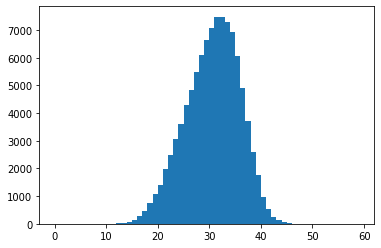

In [175]:
repeated_hist(JT, bins=range(60))

22.14894

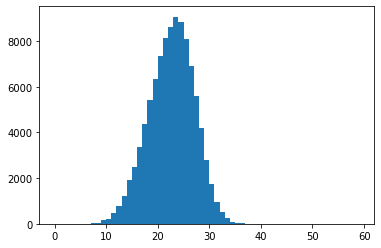

In [74]:
repeated_hist(JB, bins=range(60))

The next two players have bi-modal distributions; some games they score a lot, some games not:

14.02875

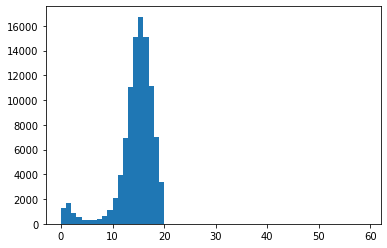

In [75]:
repeated_hist(TR, bins=range(60))

11.69169

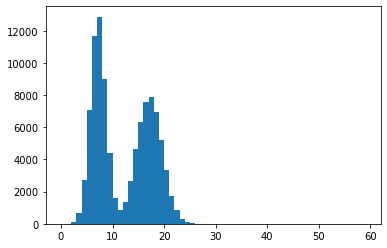

In [76]:
repeated_hist(AH, bins=range(60))

The fifth "player" (actually the sum of all the other players on the team, not really Aron Baymes, or they would have easily defeated the Cavaliers!) looks like this:

36.33028

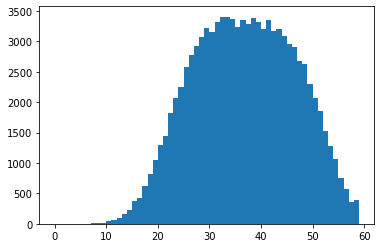

In [77]:
repeated_hist(AB, bins=range(60))

Go ahead, add more players to the Celtics, each with their own scoring distribution. Modify and use the below template:
```python
def XX(): return posint(gauss(15.1, 3) + 3 * triangular(1, 4, 13)) # 30.1
```

Add then in the cell below:

30.09251

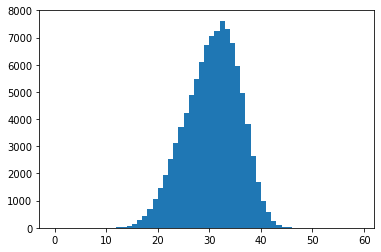

In [85]:
def XX(): return posint(gauss(15.1, 3) + 3 * triangular(1, 4, 13)) # 30.1
repeated_hist(XX, bins=range(60))

Now we define the team score to be the sum of the five players, and look at the distribution. Don't forge to add your own players!

114.25589

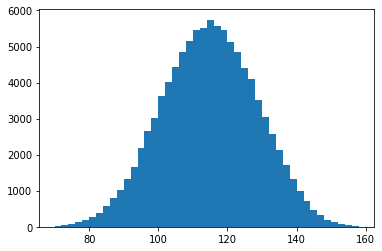

In [86]:
def GSW(): return JT() + JB() + TR() + AH() + AB()  # + ... add your own players!

repeated_hist(GSW, bins=range(70, 160, 2))

Sure enough, this looks very much like a **normal distribution**! 

The Central Limit Theorem holds, and that is why the statistics of NBA teams are so *predictable*. 

When you have a lot of data, you have little doubt, and the Data Science is *easy*. Deep Learning ANNs are very good at building hypersurfaces that match all the state variables of past outcomes. When you are asked to predict new outcomes based on a partial subset of state variables (independent variables), machines just project the lower dimensional hypersurface onto the higher dimensional hypersurface (stored in very compact form) and fill in the missing dimensions in order to predict the dependent variables. 

<br />
<center>
    <img src="ipynb.images/manifold.jpg" width=300 />
</center>


We saw just a few days ago how machines can even predict non-linear functions if we give them tons of data, but when the data is not enough, they *cannot* predict!

So what do we do when we *don't have enough data*? Do we just give up? We'll see next week how **Bayesian statistics** come to the rescue, *when we have to deal with doubt*.

# Conclusion¶
We've built a framework for estimating probabilities that will come in handy when you are asked to build data models. We *started playing* with **Bayes' theorem**, a *pillar* of data science, and we started learning how to answer typical Data Science interview questions, which you should *always* answer in python because you *will* run out of space on the whiteboard if you use squiggly brackets and other languages! 

Next week we move on to statistical modeling and inference. 

**Modeling** (one `l` or 2 `l`s? See [here](https://www.grammarly.com/blog/modeling-or-modelling/)) happens when data is scarce and precious and hard to obtain, for example in social sciences and settings where it is difficult to conduct large-scale controlled experiments. With small data it is important to quantify uncertainty and that’s precisely what Bayesian approaches are good at. **Inference** refers to how you learn parameters of your model (Markov Chain Monte Carlo, or MCMC, albeit computationally expensive, is one of the most important methods for statistical inference), which is especially important with Bayesian Machine Learning, where we can actually inquire with Machines why this or that action was undertaken.

*Alexa, why did you lower the temperature in the bedroom?* **Because your wife told me that whenever you start snoring, John, colder tempreatures make you bundle up under the cover and you snore less**. 

<br />
<center>
    <img src="ipynb.images/echo.jpg" width=200 />
</center>

Best advice for interviews: Be explicit about what the problem says, have the interviewer verify the working hypotheses, be methodical about defining the sample space, be careful in counting the number of outcomes in the numerator and denominator, and finally use Bayes' theorem (or 1 minus the negation) whenever possible because you will be doing calculations by hand on a whiteboard!

<br />
<center>
    <img src="ipynb.images/jobinterview.jpg" width=400 />
</center>

# Homework for next week: Introduction to Data Science for Sports

You will exercise your knowledge of probabilities and writing down logic with python.

<br />
<center>
    <img src="ipynb.images/f1races.png" width=800 />
</center>

Question 1.1 (20 points) There are a number of F1 races coming up: 
- Singapore GP: Date: Sun, Sep 22, 8:10 AM
- Russian GP: Date: Sun, Sep 29, 7:10 AM
- Japanese GP: Date: Sun, Oct 13, 1:10 AM
- Mexican GP Date: Sun, Oct 13, 1:10 AM

We are just before the Singaporean Grand Prix (this coming weekend) and the Russian Grand Prix the weekend after, as you can see [schedule](https://www.formula1.com/en/racing/2019.html). 

The 2019 driver standings are given [here](https://www.formula1.com/en/results.html/2019/drivers.html). Assume these standings for this weekend, even though they are final season standings. Given these standings (please do not use team standings given on the same Web site, use ***driver standings***), what is the Probability Distribution for each F1 driver to win the Singaporean Grand Prix? What is the Probability Distribution for each F1 driver to win *both* the Singaporean and Russian Grand Prix? What is the probability for Mercedes to win both races? What is the probability for Mercedes to win at least one race? Note that Mercedes, and each other racing team, has two drivers per race. Assume that Singaporean grand prix standings are not going to change driver standings by much, so you can use same standings for both races.

Question 1.2 (30 points) If Mercedes wins the first race, what is the probability that Mercedes wins the next one? If Mercedes wins at least one of these two races, what is the probability Mercedes wins both races? How about Ferrari, Alfa Romeo, and McLaren?

Question 1.3 (50 points) Mercedes wins at least one of these two races on a **rainy** day. What is the probability Mercedes wins both races, assuming races can be held on either rainy, sunny, cloudy, snowy or foggy days? Assume that rain, sun, clouds, snow, and fog are the *only possible weather conditions* on race tracks.

You need to provide *proof* for your answers. `I think it's one in a million because Mercedes sucks and I like Ferrari a lot more` is not a good answer. Leverage the counting framework in this workbook!

Hint: Use SingaporeanGrandPrix, or `SGP` to denote the Probability Distribution given by F1 driver wins. Write driver initials as keys and driver wins as values in a dictionary that you pass to our function `ProbDist`..

<b>Question 1</b>

In [11]:
Mercedes = ['LH', 'VB'];
Ferrari = ['CL', 'SV'];
AlfaRomeo = ['KR', 'AG'];
McLaren = ['CS', 'LN'];

1.1: What is the Probability Distribution for each F1 driver to win the Singaporean Grand Prix?

In [51]:
SGP = ProbDist(
    LH = 413, VB = 326, MV = 278, CL = 264, SV = 240, CS = 96, PG = 95, AA = 92, DR = 54, SP = 52, 
    LN = 49, KR = 43, DK = 37, NH = 37, LS = 21, KM = 20, AG = 14, RG = 8, RK = 1, GR = 0)
SGP

{'LH': 0.1929906542056075,
 'VB': 0.15233644859813084,
 'MV': 0.12990654205607477,
 'CL': 0.1233644859813084,
 'SV': 0.11214953271028037,
 'CS': 0.044859813084112146,
 'PG': 0.04439252336448598,
 'AA': 0.04299065420560748,
 'DR': 0.025233644859813085,
 'SP': 0.024299065420560748,
 'LN': 0.022897196261682243,
 'KR': 0.020093457943925235,
 'DK': 0.017289719626168223,
 'NH': 0.017289719626168223,
 'LS': 0.009813084112149532,
 'KM': 0.009345794392523364,
 'AG': 0.0065420560747663555,
 'RG': 0.003738317757009346,
 'RK': 0.00046728971962616824,
 'GR': 0}

1.2: What is the Probability Distribution for each F1 driver to win both the Singaporean and Russian Grand Prix?

In [13]:
def joint(A, B):
    """The joint distribution of two independent probability distributions. 
    Result is all entries of the form {a: P(a)*P(a)}"""
    return ProbDist({a + ' wins SGP and ' + b + ' wins RGP': A[a] * A[b] for a in A for b in B })
twoGames = joint(SGP, SGP)

In [14]:
for a in list(SGP.keys()):
    winTwice = {k:v for (k,v) in twoGames.items() if a == k[0:2] and a == k[16:18]}
    print(winTwice)

{'LH wins SGP and LH wins RGP': 0.037245392610708354}
{'VB wins SGP and VB wins RGP': 0.023206393571490954}
{'MV wins SGP and MV wins RGP': 0.016875709668966718}
{'CL wins SGP and CL wins RGP': 0.015218796401432434}
{'SV wins SGP and SV wins RGP': 0.012577517687134243}
{'CS wins SGP and CS wins RGP': 0.0020124028299414788}
{'PG wins SGP and PG wins RGP': 0.001970696130666433}
{'AA wins SGP and AA wins RGP': 0.0018481963490261156}
{'DR wins SGP and DR wins RGP': 0.0006367368329111712}
{'SP wins SGP and SP wins RGP': 0.000590444580312691}
{'LN wins SGP and LN wins RGP': 0.0005242815966459952}
{'KR wins SGP and KR wins RGP': 0.000403747052144292}
{'DK wins SGP and DK wins RGP': 0.0002989344047515066}
{'NH wins SGP and NH wins RGP': 0.0002989344047515066}
{'LS wins SGP and LS wins RGP': 9.629661979212154e-05}
{'KM wins SGP and KM wins RGP': 8.734387282732114e-05}
{'AG wins SGP and AG wins RGP': 4.279849768538737e-05}
{'RG wins SGP and RG wins RGP': 1.3975019652371384e-05}
{'RK wins SGP and

#### Cause the driver wins one race is an independent event, the probability of one driver wins twice is the square of each single win probability:

1.3: What is the probability for Mercedes to win both races?

In [15]:
theSituationOfMercedesWinsBothRaces = [i + ' ' + j for i in Mercedes for j in Mercedes] 
print (theSituationOfMercedesWinsBothRaces)
mercedesWinTwice = { }
for situation in theSituationOfMercedesWinsBothRaces:
    mercedesWinTwice.update({k:v for (k,v) in twoGames.items() if situation[0:2] == k[0:2] and situation[3:5] == k[16:18]})
theProbability = sum(mercedesWinTwice.values())
theProbability
### print('Probability of Ferrari drivers winning both races is: ' + str(theProbability))
### situation.values() for situation in mercedesWinTwice

['LH LH', 'LH VB', 'VB LH', 'VB VB']


0.11925080793082363

#### 'LH LH', 'LH VB', 'VB LH', 'VB VB' are the total situations that Ferrari drivers winning both races, the Probability of Mercedes drivers winning both races is: 0.11925080793082363

1.4: What is the probability for Mercedes to win at least one race ?

In [16]:
SGPWithoutMercedes = ['MV','CL','SV','CS','PG','AA','DR','SP','LN','KR','DK','NH','LS','KM','AG','RG','RK','GR']
twoGamesWithoutMercedes = [a + ' wins SGP and ' + b + ' wins RGP' for a in SGPWithoutMercedes for b in SGPWithoutMercedes ]
twoGamesWithoutMercedes

theSituationOfMercedeswoundntWinAnyOneOfRaces = { a:twoGames[a] for a in twoGamesWithoutMercedes}
theProbabilityOfMercedeswoundntWinAnyOneOfRaces = sum(theSituationOfMercedeswoundntWinAnyOneOfRaces.values())
theProbabilityOfMercedesWinAtLeastOneRaces = 1 - theProbabilityOfMercedeswoundntWinAnyOneOfRaces
theProbabilityOfMercedesWinAtLeastOneRaces

0.5714033976766529

#### The probability of Mercedes to win at least one race is same as using 1 to deduct the probability of Mercedes wouldn't win each race. so the probability of Mercedes to win at least one race is 0.5714033976766529.

<b>Question 2</b>

2.1: If Mercedes wins the first race, what is the probability that Mercedes wins the next one?

In [17]:
SGP['LH'] + SGP['VB']

0.34532710280373835

#### Because we assume that Singaporean grand prix standings are not going to change driver standings by much, so each race can be think as a independent event, which means the probability of Mercedes wins the next one is the sum of the probability of two drivers win one game. Which is 0.34532710280373835.

2.2: If Mercedes wins at least one of these two races, what is the probability Mercedes wins both races?

In [18]:
### function of Mercedes will win at least one of these two races:
def MercedesWinAtLeastOnce(outcome): return outcome.count('LH') + outcome.count('VB') >= 1
### function of Mercedes will win at BOTH races:
def MercedesWinBoth(outcome): return outcome.count('LH') + outcome.count('VB') == 2

In [19]:
def jointForWinBoth(A, B, pred):
    return ProbDist({a  + ' wins SGP and ' + b + ' wins RGP': A[a] * B[b] for a in A for b in B if pred
                     ( a + ' wins SGP and ' + b + ' wins RGP')})

In [20]:
p(MercedesWinBoth, jointForWinBoth(SGP, SGP, MercedesWinAtLeastOnce ))

0.20869810787913015

#### For this question, the probability of Mercedes win twice is the square of the probability Mercedes win once. but the sample space is 1 reduce Mercedes lose both two race. so the probability Mercedes wins both races given that it won at least one of them is 0.20869810787913015

2.3: If Ferrari wins the first race, what is the probability that Ferrari wins the next one?

In [21]:
SGP['CL'] + SGP['SV']

0.23551401869158878

#### Because we assume that Singaporean grand prix standings are not going to change driver standings by much, so each race can be think as a independent event, which means the probability of Ferrari wins the next one is the sum of the probability of two drivers win one game. Which is 0.23551401869158878.

2.4: If Ferrari wins at least one of these two races, what is the probability Ferrari wins both races?

In [22]:
### function of Mercedes will win at least one of these two races:
def FerrariWinAtLeastOnce(outcome): return outcome.count('CL') + outcome.count('SV') >= 1
### function of Mercedes will win at BOTH races:
def FerrariWinBoth(outcome): return outcome.count('CL') + outcome.count('SV') == 2

In [23]:
def jointForWinBoth(A, B, pred):
    return ProbDist({a  + ' wins SGP and ' + b + ' wins RGP': A[a] * B[b] for a in A for b in B if pred
                     ( a + ' wins SGP and ' + b + ' wins RGP')})

In [24]:
p(FerrariWinBoth, jointForWinBoth(SGP, SGP, FerrariWinAtLeastOnce ))

0.13347457627118642

#### For this question, the probability of Ferrari win twice is the square of the probability Ferrari win once. but the sample space is 1 reduce Ferrari lose both two races. so the probability Ferrari wins both races given that it won at least one of them is 0.13347457627118642

2.5: If Alfa Romeo wins the first race, what is the probability that Alfa Romeo wins the next one?

In [25]:
SGP['KR'] + SGP['AG']

0.02663551401869159

#### Because we assume that Singaporean grand prix standings are not going to change driver standings by much, so each race can be think as a independent event, which means the probability of Alfa Romeo wins the next one is the sum of the probability of two drivers win one game. Which is 0.02663551401869159.

2.6: If Alfa Romeo wins at least one of these two races, what is the probability Alfa Romeo wins both races?

In [26]:
## function of AlfaRomeo will win at least one of these two races:
def AlfaRomeoWinAtLeastOnce(outcome): return outcome.count('KR') + outcome.count('AG') >= 1
## function of AlfaRomeo will win at BOTH races:
def AlfaRomeoWinBoth(outcome): return outcome.count('KR') + outcome.count('AG') == 2

In [27]:
def jointForWinBoth(A, B, pred):
    return ProbDist({a  + ' wins SGP and ' + b + ' wins RGP': A[a] * B[b] for a in A for b in B if pred
                     ( a + ' wins SGP and ' + b + ' wins RGP')})

In [28]:
p(AlfaRomeoWinBoth, jointForWinBoth(SGP, SGP, AlfaRomeoWinAtLeastOnce ))

0.013497513615912863

#### For this question, the probability of Alfa Romeo win twice is the square of the probability Alfa Romeo win once. but the sample space is 1 reduce Alfa Romeo lose both two races. so the probability Alfa Romeo wins both races given that it won at least one of them is 0.013497513615912863

2.7: If McLaren wins the first race, what is the probability that McLaren wins the next one?

In [29]:
SGP['CS'] + SGP['LN']

0.06775700934579439

#### Because we assume that Singaporean grand prix standings are not going to change driver standings by much, so each race can be think as a independent event, which means the probability of McLaren wins the next one is the sum of the probability of two drivers win one game. Which is 0.06775700934579439.

2.8: If McLaren wins at least one of these two races, what is the probability McLaren wins both races?

In [30]:
### function of McLaren will win at least one of these two races:
def McLarenWinAtLeastOnce(outcome): return outcome.count('CS') + outcome.count('LN') >= 1
### function of McLaren will win at BOTH races:
def McLarenWinBoth(outcome): return outcome.count('CS') + outcome.count('LN') == 2

In [31]:
def jointForWinBoth(A, B, pred):
    return ProbDist({a  + ' wins SGP and ' + b + ' wins RGP': A[a] * B[b] for a in A for b in B if pred
                     ( a + ' wins SGP and ' + b + ' wins RGP')})

In [32]:
p(McLarenWinBoth, jointForWinBoth(SGP, SGP, McLarenWinAtLeastOnce ))

0.03506650544135429

#### For this question, the probability of McLaren win twice is the square of the probability McLaren win once. but the sample space is 1 reduce Mercedes lose both two races. so the probability McLaren wins both races given that it won at least one of them is 0.03506650544135429

<b>Question 3</b>

Mercedes wins at least one of these two races on a **rainy** day. What is the probability Mercedes wins both races, assuming races can be held on either rainy, sunny, cloudy, snowy or foggy days? Assume that rain, sun, clouds, snow, and fog are the *only possible weather conditions* on race tracks.

The list of weather is [Rainy, Sunny, Cloudy, Snowy, Foggy ]

We assume the weather conditions are with equal probability:

In [56]:
weather = {'Rainy': 0.2, 'Sunny': 0.2, 'Cloudy': 0.2, 'Snowy': 0.2, 'Foggy': 0.2}

The probability of each driver win the race in different weather conditions is equal, which is 1/5 of origin probability

In [53]:
def joint(A, B, sep=''):
    return ProbDist({a + sep + b: A[a] * B[b] for a in A for b in B})

In [62]:
winOneRaceConditions  = joint(SGP, weather, ' ')
winOneRaceConditions

{'LH Rainy': 0.03859813084112147,
 'LH Sunny': 0.03859813084112147,
 'LH Cloudy': 0.03859813084112147,
 'LH Snowy': 0.03859813084112147,
 'LH Foggy': 0.03859813084112147,
 'VB Rainy': 0.03046728971962615,
 'VB Sunny': 0.03046728971962615,
 'VB Cloudy': 0.03046728971962615,
 'VB Snowy': 0.03046728971962615,
 'VB Foggy': 0.03046728971962615,
 'MV Rainy': 0.02598130841121494,
 'MV Sunny': 0.02598130841121494,
 'MV Cloudy': 0.02598130841121494,
 'MV Snowy': 0.02598130841121494,
 'MV Foggy': 0.02598130841121494,
 'CL Rainy': 0.024672897196261666,
 'CL Sunny': 0.024672897196261666,
 'CL Cloudy': 0.024672897196261666,
 'CL Snowy': 0.024672897196261666,
 'CL Foggy': 0.024672897196261666,
 'SV Rainy': 0.022429906542056063,
 'SV Sunny': 0.022429906542056063,
 'SV Cloudy': 0.022429906542056063,
 'SV Snowy': 0.022429906542056063,
 'SV Foggy': 0.022429906542056063,
 'CS Rainy': 0.008971962616822425,
 'CS Sunny': 0.008971962616822425,
 'CS Cloudy': 0.008971962616822425,
 'CS Snowy': 0.00897196261682

In [61]:
winTwoRacesConditions = joint(winOneRaceConditions, winOneRaceConditions, ' ')
len(winTwoRacesConditions)

10000

In [85]:
def MercedesWinsAtLeastOneOfTheseTwoRacesOnARainyDayFilter(outcome): return 'LH Rainy' in outcome or 'VB Rainy' in outcome

In [86]:
def MercedesWinsBothRacesFilter(outcome): return 'LH' in outcome or 'VB' in outcome

In [87]:
def jointForWinBoth(A, B, pred, sep =' '):
    return ProbDist({a  + sep + b : A[a] * B[b] for a in A for b in B if pred ( a + sep + b )})

In [95]:
AlLSituationsOfMercedesWinsAtLeastOneOfTheseTwoRacesOnARainyDay = jointForWinBoth(winOneRaceConditions, winOneRaceConditions, MercedesWinsAtLeastOneOfTheseTwoRacesOnARainyDayFilter, ' ')

In [96]:
len(AlLSituationsOfMercedesWinsAtLeastOneOfTheseTwoRacesOnARainyDay)

396

According above, the total number of situation of all drivers match in one of five weathers is 1000, the number of the situation of Mercedes Wins atleast one of the races is 396  

In [97]:
def MercedesWinBoth(outcome): return outcome.count('LH') + outcome.count('VB') == 2

So the sample space is AlLSituationsOfMercedesWinsAtLeastOneOfTheseTwoRacesOnARainyDay reqired situation is MercedesWinBoth

In [98]:
p(MercedesWinBoth, AlLSituationsOfMercedesWinsAtLeastOneOfTheseTwoRacesOnARainyDay)

0.3219108465224334

#### So finally the probability of two Mercedes wins when we know that Ferrari wins at least one race on a rainy day is 0.3219108465224334